In [24]:
import requests
import pymongo
import json
import psycopg2
import pandas as pd
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def mongoConnection():
    """ Function to connect to Mongo Server"""
    try:
        mongoClient = pymongo.MongoClient("mongodb://localhost:27017/")
        mongoDB = mongoClient["prisonAdmissions"]
        mongoCollection = mongoDB["prisonAdmissions"]
        return mongoCollection
    except Exception as error:
        print (error)
        
def postgreSQLConnection():
    """ Function to connect to PostgreSQL Server """
    try:
        DBConnection = psycopg2.connect(
            database = "PrisonAdmissions", 
            user = "postgres", 
            password = "dap", 
            host = "127.0.0.1", 
            port = "5432"
        )
        return DBConnection
    except Exception as error:
        print (error)

def fetchData(URL):
    """ Function to fetch data via an API """
    try:
        response = requests.get(URL) # Fetch data from the URL
        prisonAdmissionsJson = response.json()
        return prisonAdmissionsJson # return data
    except Exception as error:
        print (error)

In [91]:
mongoCollection = mongoConnection() # Connection to mongoDB

prisonAdmissionsJson = fetchData("https://data.ny.gov/api/views/m2rg-xjan/rows.json?accessType=DOWNLOAD") # Fetch data from the URL
prisonAdmissionsDict = {} # Save the JSON data in Dictionary

# Extracting data from the Prison admission JSON
# Step one) Extract meta data from the JSON. Meta contains all the column names
Index = 0 # Index 
for keys, values in enumerate(prisonAdmissionsJson["meta"]["view"]["columns"]):
    # print (values)
    # Note:- While cleaning the data ignore all 'id' which are -1
    prisonAdmissionsDict[Index] = {} # Adding an empty dictionary at the key (index)
    prisonAdmissionsDict[Index]["data"] = values # Row data
    prisonAdmissionsDict[Index]["type"] = "meta" # Type of data i.e. meta/data
    mongoCollection.insert_one(prisonAdmissionsDict[Index]) # Insert a row in mongodb
    Index = Index + 1 # Increment the Counter
# print(prisonAdmissionsDict)

In [92]:
# Step two) Extract data from the JSON. Data contains all the rows and saving into MongoDB
for keys, values in enumerate(prisonAdmissionsJson["data"]):
    prisonAdmissionsDict[Index] = {} # Adding an empty dictionary at the key (index)
    prisonAdmissionsDict[Index]["data"] = values # Row data
    prisonAdmissionsDict[Index]["type"] = "data" # Type of data i.e. meta/data
    # Insert a row in mongodb
    mongoCollection.insert_one(prisonAdmissionsDict[Index]) 
    Index = Index + 1 # Increment the Counter
    
# print (prisonAdmissionsDict)

In [93]:
# Step three) Extract data from MongoDB & Insert into PostgreSQL
DBConnection = postgreSQLConnection() # PostgreSQL connection
DBCursor = DBConnection.cursor()
try:
    prisonAdmissionCleaned = {}
    mongoResults = mongoCollection.find({ "type": "data", "data": "2018" }) # Return all the data from the collection
    for keys, values in enumerate(mongoResults):
        # print (values["data"])
        # Mapping values to keys
        prisonAdmissionCleaned[keys] = {} # Adding an empty dictionary at the key (index)
        prisonAdmissionCleaned[keys]["AdmissionYear"] = values["data"][8] 
        prisonAdmissionCleaned[keys]["AdmissionMonth"] = values["data"][9]  
        prisonAdmissionCleaned[keys]["MonthCode"] = values["data"][10]
        prisonAdmissionCleaned[keys]["AdmissionType"] = values["data"][11]
        prisonAdmissionCleaned[keys]["CountyOfCommitment"] = values["data"][12]  
        prisonAdmissionCleaned[keys]["LastKnownResidenceCounty"] = values["data"][13]
        prisonAdmissionCleaned[keys]["Gender"] = values["data"][14]
        prisonAdmissionCleaned[keys]["AgeOfAdmission"] = values["data"][15]
        prisonAdmissionCleaned[keys]["MostSeriousCrime"] = values["data"][16]
        
        # Insert data into PostgreSQL
        Query = """
            Insert into "PrisonAdmissions" ("AdmissionYear", "AdmissionMonth", "MonthCode", "AdmissionType", "CountyOfCommitment", "LastKnownResidenceCounty", "Gender", "AgeOfAdmission", "MostSeriousCrime")
                VALUES
            (%s, %s, %s, %s, %s, %s, %s, %s, %s)
        """
        Result = (prisonAdmissionCleaned[keys]["AdmissionYear"], prisonAdmissionCleaned[keys]["AdmissionMonth"], prisonAdmissionCleaned[keys]["MonthCode"], prisonAdmissionCleaned[keys]["AdmissionType"], prisonAdmissionCleaned[keys]["CountyOfCommitment"], prisonAdmissionCleaned[keys]["LastKnownResidenceCounty"], prisonAdmissionCleaned[keys]["Gender"], prisonAdmissionCleaned[keys]["AgeOfAdmission"], prisonAdmissionCleaned[keys]["MostSeriousCrime"])
        DBCursor.execute(Query, Result)
    DBConnection.commit() # Commit transactions
    # print(prisonAdmissionCleaned)
except Exception as error:
    print(error)

In [5]:
# Step four) Extract data from PostgreSQL
DBConnection = postgreSQLConnection() # PostgreSQL connection
try:
    Query = """Select * 
                FROM "PrisonAdmissions"
                """
    prisonAdmissionsDF = pd.read_sql_query(Query, DBConnection)
except Exception as error:
    print (error)

In [6]:
def mapAge(age):
    """ Group Age """
    age = int(age)
    if age <= 18:
        return '< 18'
    elif age >= 19 and age <= 24:
        return '18-24'
    elif age >= 25 and age <= 44:
        return '25-44'
    elif age >= 45 and age <= 64:
        return '45-64'
    else:
        return '65+'

def mapCounty(county):
    """ Group County """
    if county == 'BRONX':
        return 'BRONX'
    elif county == 'KINGS':
        return 'BROOKLYN'
    elif county == 'NEW YORK':
        return 'MANHATTAN'
    elif county == 'QUEENS':
        return 'QUEENS'
    elif county == 'RICHMOND':
        return 'STATEN ISLAND'
    else:
        return 'NA'

prisonAdmissionsDF["AgeRange"] = prisonAdmissionsDF['AgeOfAdmission'].map(mapAge) # Group age
prisonAdmissionsDF["Borough"] = prisonAdmissionsDF["CountyOfCommitment"].map(mapCounty) # Group County     

In [7]:
prisonAdmissionsDF.head()

,AdmissionYear,AdmissionMonth,MonthCode,AdmissionType,CountyOfCommitment,LastKnownResidenceCounty,Gender,AgeOfAdmission,MostSeriousCrime,AgeRange,Borough
0,2018,JANUARY,1,NEW COURT COMMITMENT,BRONX,MISSING,MALE,40,CPCS 3RD,25-44,BRONX
1,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,17,ASSAULT 2ND,< 18,NA
2,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,17,ASSAULT 2ND,< 18,NA
3,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,20,CPCS 5TH,18-24,NA
4,2018,JANUARY,1,NEW COURT COMMITMENT,ALBANY,MISSING,MALE,21,CPCS 3RD,18-24,NA


In [ ]:
DataFrame.to_csv('PrisonAdmissions.csv', sep=',')

In [10]:
# # Step five) EDA
# # Graph 1) Admission type based on counties
# graphOneDF = prisonAdmissionsDF.groupby(["Borough", "AdmissionType"]).count()[['AgeRange']].reset_index()
# graphOneDF = graphOneDF[graphOneDF["Borough"] != "NA"].sort_values(by = "AgeRange", ascending = False)
# # print (graphOneDF)
# ####
# # Structure to follow for Stack bar chart
# # Data = {
# #     "Ireland": { "x": ["Jail", "Murder"], "y" : [1, 2, 4] },
# #     "India": { "x": ["Jail", "Murder"], "y" : [1, 2, 4] }
# # }
# ####
# admissionType = {}
# for keys, values in graphOneDF.iterrows():
#     dictKey = values["AdmissionType"].title()
#     # print (dictKey)
#     # Define dictionary indexes
#     if dictKey not in admissionType: # Check if the key exist in the dictionary
#         admissionType[dictKey] = {}
#         admissionType[dictKey]["x"] = []
#         admissionType[dictKey]["y"] = []
    
#     admissionType[dictKey]["x"].append(values["Borough"].title())    
#     admissionType[dictKey]["y"].append(values["AgeRange"])
# # print(admissionType)     

# graphList = []
# for keys, values in enumerate(admissionType):
#     graphList.append(go.Bar(
#         name = values,
#         x = admissionType[values]["x"],
#         y = admissionType[values]["y"]
#     ))
# fig = go.Figure()
# fig = go.Figure(data = graphList)
# # Change the bar mode
# fig.update_layout(barmode='stack')
# fig.show()

# # Graph 2) Gender wise admission type
# graphTwoDF = prisonAdmissionsDF.groupby(["AdmissionType", "Gender"]).count()[['AgeRange']].reset_index()
# graphTwoDF = graphTwoDF.sort_values(by = "AgeRange", ascending = False)
# # print (graphTwoDF)
# fig = px.bar(graphTwoDF, x = "Gender", y = "AgeRange", color = 'AdmissionType', barmode = 'group', height = 400)
# fig.update_layout(xaxis_title = "Gender", yaxis_title = "No. of Admissions")
# fig.show()

# # Graph 3) Month wise counts
# prisonAdmissionsDF = prisonAdmissionsDF[prisonAdmissionsDF["Borough"] != "NA"] # Remove NA values
# # print (prisonAdmissionsDF)

# graphThreeDF = prisonAdmissionsDF.groupby(["AdmissionMonth", "MonthCode"]).count()[['AgeRange']].reset_index()
# prisonAdmissionsDF["MonthCode"] = pd.to_numeric(prisonAdmissionsDF["MonthCode"]) # Convert column to INT
# graphThreeDF = graphThreeDF.sort_values("MonthCode")
# # print (graphThreeDF)
# fig = px.bar(graphThreeDF, x = "AdmissionMonth", y = "AgeRange", height = 400)
# fig.update_layout(
#     title = "Plot Title",
#     xaxis_title = "x Axis Title",
#     yaxis_title = "y Axis Title"
# )
# fig.show()

graphFourDF = prisonAdmissionsDF.groupby(["MostSeriousCrime", "AgeRange"]).count()[["Borough"]].reset_index()
graphFourDF = graphFourDF.sort_values(by = "Borough", ascending = False)
# print (graphFourDF)

              MostSeriousCrime AgeRange  Borough
101           C POS WEAPON 2ND    25-44     1017
232                   CSCS 3RD    25-44      916
150                   CPCS 3RD    25-44      877
85                BURGLARY 2ND    25-44      798
90                BURGLARY 3RD    25-44      778
62                 ASSAULT 2ND    25-44      607
459                ROBBERY 2ND    25-44      540
454                ROBBERY 1ST    25-44      438
91                BURGLARY 3RD    45-64      378
100           C POS WEAPON 2ND    18-24      376
233                   CSCS 3RD    45-64      354
464                ROBBERY 3RD    25-44      315
310           GRAND LARCEN 4TH    25-44      311
160                   CPCS 5TH    25-44      300
86                BURGLARY 2ND    45-64      297
458                ROBBERY 2ND    18-24      295
164     CR POS WEAP 3 SUB1,2,3    25-44      256
57        ASSAULT 1ST B FELONY    25-44      237
151                   CPCS 3RD    45-64      233
132               CO

AxesSubplot(0.125,0.125;0.775x0.755)


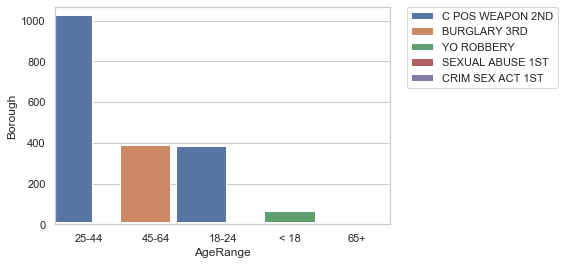

In [70]:
sns.set(style="whitegrid")
maxCrimes = graphFourDF.groupby(["AgeRange"])["Borough"].transform(max) == graphFourDF["Borough"]
ax = sns.barplot(x="AgeRange", y="Borough", hue = "MostSeriousCrime", data = graphFourDF[maxCrimes])
# print (graphFourDF[maxCrimes])
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
    
change_width(ax, 0.75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print (ax)